In [57]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import integrate, optimize
from iminuit import Minuit
from tqdm import tqdm
from itertools import product
from multiprocessing import Pool
plt.rcParams.update({'font.size': 18})

In [4]:
# Fixed the bins, colors, mass arr, and labels for all plots.
# 1. bins related parameters (reconstucted top mass)
bins_width = 1
top_bins_min, top_bins_max = 120, 230
top_bins = np.arange(top_bins_min, top_bins_max+1, bins_width)
top_bins_mid = top_bins[:-1]+bins_width/2
top_bins_dense = np.linspace(top_bins_min, top_bins_max, 1000)

# 2. bins related parameters (reconstucted W mass)
W_bins_min, W_bins_max = 40, 120
W_bins = np.arange(W_bins_min, W_bins_max+1, bins_width)
W_bins_mid = W_bins[:-1]+bins_width/2
W_bins_dense = np.linspace(W_bins_min, W_bins_max, 1000)

# 3. True top mass related parameters
mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)

# 4. JSF related parameters
JSF_arr = [0.96, 1.0, 1.04]
JSF_dense = np.linspace(0.96, 1.04, 1000)

# 5. Other paramters
loglikeli_cut = -70
assignmment_cut = 0.12
marginal_prob_cut = 0.23
pseudo_event = 10000

# 6. Settings
states = [0, 1, 2]
state_labels = ['Unmatched', 'Incorrect', 'Correct']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
langau_fit_labels = ['Peak of Landau', 'Width of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']
twogau_fit_labels = ['Mean of first Gaussian', 'Variance of first Gaussian', 'Mean of second Gaussian', 'Variance of second Gaussian', 'Fraction of second Gaussian']


In [6]:
def get_reco_mass(h5py_file, target, JSF): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)*JSF
    # py = pt*sin(phi)*JSF
    # pz = pt*sinh(eta)*JSF
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])*JSF
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])*JSF
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])*JSF
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])*JSF
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])*JSF
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])*JSF
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])*JSF
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])*JSF
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])*JSF
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_W_mass'] = np.sqrt((dic['E1']+dic['E2'])**2
                    - (dic['px1']+dic['px2'])**2
                    - (dic['py1']+dic['py2'])**2
                    - (dic['pz1']+dic['pz2'])**2)
    
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    top_bins_min < reco_m_top < top_bins_max
    W_bins_min < reco_W_top < W_bins_max
    """
    reco_cuts = np.logical_and.reduce((dic['reconstructed_top_mass'] > top_bins_min, dic['reconstructed_top_mass'] < top_bins_max, 
                                       dic['reconstructed_W_mass'] > W_bins_min, dic['reconstructed_W_mass'] < W_bins_max))

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['klfitter/score/loglikelihood'][:]
    elif target == 'permutation_dnn': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['permutation_dnn/assignment_score'][:]
    elif target == 'spanet': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['spanet/right_target/marginal_probability'][:]
    else: return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts


In [7]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_klf_dic, W_klf_dic, state_klf_dic, cut_klf_dic, likeli_klf_dic = {}, {}, {}, {}, {}
reco_pdnn_dic, W_pdnn_dic, state_pdnn_dic, cut_pdnn_dic, likeli_pdnn_dic = {}, {}, {}, {}, {}
reco_spanet_dic, W_spanet_dic, state_spanet_dic, cut_spanet_dic, likeli_spanet_dic = {}, {}, {}, {}, {}
reco_perfect_dic, W_perfect_dic, state_perfect_dic, cut_perfect_dic = {}, {}, {}, {}

m, JSF = 173, 1
h5py_file = h5py.File(f'ttbar_testing_final_mass_variation_JSF={JSF:.2f}/ttbar_testing_{m}_gev.h5', "r")
reco_klf_dic[(m, JSF)], W_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)], cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]  = get_reco_mass(h5py_file, 'klfitter', 1)
reco_pdnn_dic[(m,JSF)], W_pdnn_dic[(m, JSF)], state_pdnn_dic[(m,JSF)], cut_pdnn_dic[(m,JSF)], likeli_pdnn_dic[(m,JSF)] = get_reco_mass(h5py_file, 'permutation_dnn', 1)
reco_spanet_dic[(m, JSF)], W_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)], cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)] = get_reco_mass(h5py_file, 'spanet', 1)
reco_perfect_dic[(m,JSF)], W_perfect_dic[(m, JSF)], state_perfect_dic[(m,JSF)], cut_perfect_dic[(m,JSF)] = get_reco_mass(h5py_file, 'target', 1)
if JSF == 1: h5py_file = h5py.File(f'ttbar_testing_final_mass_variation_JSF={JSF:.2f}/ttbar_testing_{m}_gev_with_spanet_pdnn_KLFitter.h5', "r")
reco_klf_dic[(m, JSF)], W_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)], cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]  = get_reco_mass(h5py_file, 'klfitter', 1)


/tmp/ipykernel_2048/2970215260.py:43: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_W_mass'] = np.sqrt((dic['E1']+dic['E2'])**2
/tmp/ipykernel_2048/2970215260.py:48: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2


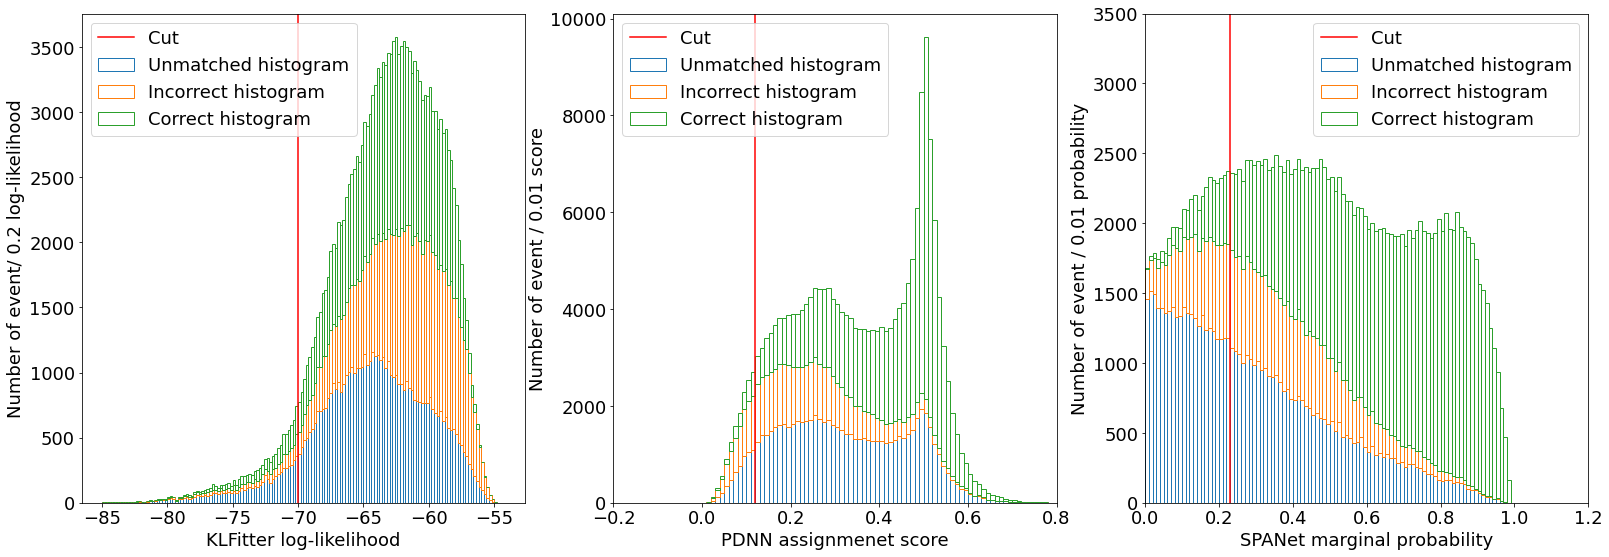

In [68]:
plt.figure(figsize=(27, 9))
plt.subplot(1, 3, 1)
bins = np.arange(-85, -54, 0.2)
h = [0]*(len(bins)-1)
for state_i in states:
    target = likeli_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)]==state_i))]
    hist, _ = np.histogram(target, bins=bins)
    plt.bar(bins[:-1]+0.1, hist, bottom=h, edgecolor=colors[state_i], width=0.2, color='None', label = state_labels[state_i] + ' histogram')
    h += hist
plt.axvline(loglikeli_cut, c='r', label='Cut')
plt.xlabel('KLFitter log-likelihood')
plt.ylabel('Number of event/ 0.2 log-likelihood')
plt.legend()

plt.subplot(1, 3, 2)
bins = np.arange(0, 0.8, 0.01)
h = [0]*(len(bins)-1)
for state_i in states:
    target = likeli_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], state_pdnn_dic[(m, JSF)]==state_i))]
    hist, _ = np.histogram(target, bins=bins)
    plt.bar(bins[:-1]+0.005, hist, bottom=h, edgecolor=colors[state_i], width=0.01, color='None', label = state_labels[state_i] + ' histogram')
    h += hist
plt.axvline(assignmment_cut, c='r', label='Cut')
plt.xlabel('PDNN assignmenet score')
plt.ylabel('Number of event / 0.01 score')
plt.xlim(-0.2, 0.8)
plt.legend(loc='upper left')

plt.subplot(1, 3, 3)
bins = np.arange(0, 1, 0.01)
h = [0]*(len(bins)-1)
for state_i in states:
    target = likeli_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)]==state_i))]
    hist, _ = np.histogram(target, bins=bins)
    plt.bar(bins[:-1]+0.005, hist, bottom=h, edgecolor=colors[state_i], width=0.01, color='None', label = state_labels[state_i] + ' histogram')
    h += hist
plt.axvline(marginal_prob_cut, c='r', label='Cut')
plt.xlabel('SPANet marginal probability')
plt.ylabel('Number of event / 0.01 probability')
plt.xlim(0, 1.2)
plt.ylim(0, 3500)
plt.legend()

plt.show()